<a href="https://colab.research.google.com/github/Bast-94/RL-DQN/blob/dqn-draft/RL_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet de Reinforcement Learning : Deep Q-Learning sur le casse-brique d'Atari

In [1]:
! pip install -q gymnasium["atari","accept-rom-license"]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 36.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00


## Présentation globale du projet

### Objectifs du projet

### Algorithme principal

#### Pseudo code de l'algorithme


$\text{Algorithme de Q-Leearning profond avec répétition d'expérience}$
1. **Initialisation:**
   - Initialiser le réseau de neurones $Q$ avec des poids aléatoires.
   - Initialiser la mémoire de relecture $D$ avec capacité maximale $N$.
   - Initialiser aléatoirement les paramètres d'apprentissage.
   - Initialiser la fonction $Q$ avec des $\theta$ aléatoire.
   - Initialiser $\hat{Q}$ avec $\theta^⁻ = \theta$.

2. **Pour chaque épisode:**
   - Initialiser l'environnement et l'état initial $s_1=\{x_1\}$
   - Appliquer le prétraitement $\phi_1 = \phi(s_1)$
   
   3. **Pour chaque étape $t$ de l'épisode:**
      - Choisir l'action $a_t$ avec la politique $\varepsilon$-greedy
        - $\mathbb{P}(a_t = argmax_a(Q(s_t,a;\theta)) = 1 - \varepsilon$
        - $\mathbb{P}(a_t = \text{random\_sample(}A)) = \varepsilon$
      - Exécuter l'action $a_t$, observer la récompense $r_t$ et l'état suivant $s_{t+1}$
      - Stocker la transition $(s_t, a_t, r_{t}, s_{t+1})$ dans la mémoire de relecture $D$
      - Affecter $s_{t+1}=s_t,a_t,x_{t+1}$
      - Prétraitement de $s_{t+1}$ : $\phi_{t+1}=\phi(s_{t+1})$
      - Échantillonner un lot aléatoire de transitions $(s_i, a_i, r_i, s_{i+1})$ de $D$
      - Calculer la vérité terrain $y_i$ pour chaque transition $(s_i, a_i, r_i, s_{i+1})$ en utilisant le réseau $\hat{Q}$ aux paramètre $\theta^-$
      - Cloner $Q$ dans $\hat{Q}$ toutes les $C$ étapes
      


#### Détails des variables
- $Q$ : Fonction de qualité qui pour un couple état-action évalue à quel point une action dans un état donné est favorable.
- $C$ : Nombre d'étapes à laquelle $\hat{Q}$ se met à jour sur $Q$.
- $\hat{Q}$ : Target Network , il correspond à une version ancienne de $Q$ avec des paramètres $\theta^-$ sur les $C$ dernières étapes.
- $\theta$ : Correspond aux paramètres du réseau de neurones.
- ${A}$ : L'ensemble des actions possibles.
- $a_t$ : L'action faite par l'agent à l'étape $t$.
- $x_t$ : Correspond à l'image brut du jeu à l'étape $t$.
- $s_t$ : Correspond à une séquence de couples action-image $\{a_i \times x_i\}_{i\lt t}$ .
- $\phi_t$ : Correspond au pré-traitement de l'état $s_t$ (Plus de détails dans la suite du notebook).
- $\varepsilon \in [0,1]$ : Probabilité de choisir une action aléatoire.
- $r_t$ : Récompense obtenue par la réalisation de l'action $a_t$ à l'instant $s_t$
- $D$ : Mémoire de relecture.
- $N$ : Nombre de simulations.

## Démarche de recherche et implémentation

In [2]:
from torch import nn
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms as transforms
import copy
from time import time

#### Prétraitement des données

In [3]:
def preprocess_image(img_array:np.array) -> np.array :
  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((84, 84)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor()])
  return transform(img_array)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


new_img.size() = torch.Size([1, 84, 84])


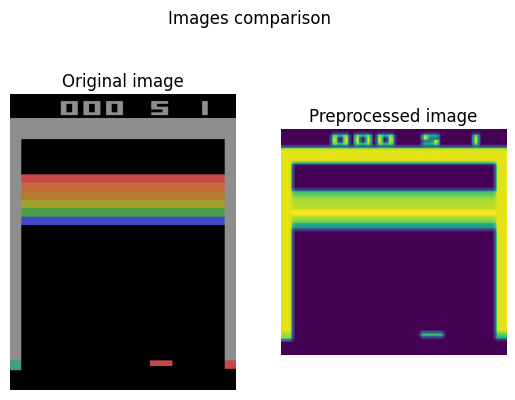

In [4]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
state_img = env.reset()[0]
fig,axes = plt.subplots(1,2)
fig.suptitle('Images comparison')
axes[0].set_title('Original image')
axes[0].imshow(state_img)
axes[0].axis('off')
new_img = preprocess_image(state_img)
print(f'{new_img.size() = }')
axes[1].axis('off')
axes[1].set_title('Preprocessed image')
axes[1].imshow(new_img.permute(1,2,0))

### Elaboration d'un modèle de de DQN

In [45]:
class DQN(nn.Module):
  def __init__(self,n_action,height,width,linear_size=1024,model_name:str=None):
    super(DQN, self).__init__()
    self.input_dimension = 1, height,width
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=self.input_dimension[0],out_channels=32,kernel_size=8,stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

    x0 = torch.zeros(1,1, height,width)
    x0 = self.conv_layers(x0)
    x0 = self.flatten(x0)
    flatten_dim = x0.shape[1]
    self.linear_layers = nn.Sequential(
        nn.Linear(flatten_dim, linear_size),
        nn.ReLU(),
        nn.Linear(linear_size,n_action)
    )

  def flatten(self,x):
    return x.view(x.shape[0],-1)

  def forward(self,x):
    x = self.conv_layers(x)
    x = self.flatten(x)
    return self.linear_layers(x)



def create_model_from_env(env: gym.Env):

  env_tensor = np.zeros(env.observation_space.shape,dtype=np.uint8)
  x = preprocess_image(env_tensor)
  _,height, width = x.shape
  n_action=env.action_space.n
  dqn = DQN(n_action=n_action,height=height, width=width)
  return dqn

testons

In [44]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
dqn = create_model_from_env(env)
x = preprocess_image(env.reset()[0])
x = x.unsqueeze(0)
output = dqn(x)
assert output.size(1) == env.action_space.n, print(f'{output.size(1)} != {env.action_space.n}')
print("Les shapes de sortie du modèle sont cohérentes.")
print(f'{output.size()}')

torch.Size([1, 6400])
Les shapes de sortie du modèle sont cohérentes.
torch.Size([1, 4])


#### Gestion de la mémoire des expériences

In [35]:
from collections import namedtuple

In [36]:
GameTransition = namedtuple('game_transition', ('initial_state', 'action', 'reward','next_state', 'done'))

In [37]:
class ExpStack(): # D
  def __init__(self, max_size:int):
    self.transitions = []
    self.max_size = max_size # N
    self.index = 0

  def enqueue(self,transition:GameTransition):
    if (len(self.transitions) < self.max_size):
      self.transitions.append(transition)
    else:
      self.transitions[self.index] = transition
    self.index +=1
    self.index = self.index % self.max_size

  def get_experiences(self,nb_exp=1):
    return random.sample(self.transitions, nb_exp)

  def __len__(self):
    return len(self.transitions)

  def __getitem__(self,index):
    return self.transitions[index]

  def sample_minibatch(self,batch_size:int=32):
    if (batch_size>=len(self)):
      return self.transitions

    return random.sample(self.transitions, batch_size)

  def tensor_batch(self,batch_size):
    batch = self.sample_minibatch(batch_size)
    batch = GameTransition(*(zip(*batch)))

    initial_state = torch.cat(batch.initial_state, dim=0)
    initial_state = initial_state.unsqueeze(1)

    next_state = torch.cat(batch.next_state, dim=0)
    next_state = next_state.unsqueeze(1)

    reward = torch.tensor(batch.reward)
    reward = reward.unsqueeze(1)

    done = torch.tensor(batch.done).float()
    done = done.unsqueeze(1)

    action = torch.tensor(batch.action)
    action = action.unsqueeze(1)

    return GameTransition(initial_state,action,reward,next_state,done)

### Lancement du modèle sur l'algorithme **"deep Q-learning with experience replay."** issu de l'article

In [38]:
Action = int
State = torch.Tensor

In [60]:
class DQNAgent():
  max_step = int(1e5)
  epsilon = 0.05
  batch_size = 32
  gamma = 0.9
  time_limit = 3600 * 2
  def __init__(self, env: gym.Env, max_experiences:int = int(1e6),update_frequency:int=5, verbose:bool=True, model_file:str=None):
    self.env = env

    self.model = create_model_from_env(env)
    self.target_model = copy.deepcopy(self.model)
    self.target_model.eval()

    self.experiences = ExpStack(max_size=max_experiences)

    self.verbose = verbose
    self.update_frequency = update_frequency
    self.legal_actions = list(range(env.action_space.n))

    self.loss_evolution = []
    self.optimizer = torch.optim.Adam(self.model.parameters())
    self.loss_func = nn.MSELoss()
    self.begin_time = time()
    self.stop = False
    self.epoch_count = 0
    if (model_file is None):
      self.model_file = 'model.pt'
    else:
      self.model_file = model_file

  def train_agent(self,nb_episodes:int):
    episode_index = 0
    while(episode_index < nb_episodes and not self.stop):
      self.make_episode()
      episode_index +=1
      if(self.verbose and episode_index % 100==0):
        print(f'{episode_index}/{nb_episodes} episodes are done')

  def make_episode(self):
    done = False
    step_index = 0
    while(step_index <self.max_step and not done and not self.stop):
      # Initialize State 1 # TODO
      self.update_time()
      current_state = preprocess_image(self.env.reset()[0])
      self.make_step(current_state)
      if(step_index % self.update_frequency == 0):
        self.update_parameters()
      step_index +=1

  def make_step(self,current_state: State | None = None):
    # Get action a_t
    a_t = self.get_action(current_state=current_state)
    # Make action and retrieve r_t and x_t
    next_state,reward,done,info = self.make_action(a_t)
    # Store transition
    transition = GameTransition(current_state,a_t,reward,next_state,done)
    self.experiences.enqueue(transition)
    # Sample minibatch of transitions
    mini_batch = self.experiences.tensor_batch(self.batch_size)
    self.train_model(mini_batch)



  def train_model(self,batch:list[GameTransition]) -> None:
    self.model.train()
    y_target = (1 - batch.done ) * self.target_model(batch.next_state) * self.gamma + batch.reward
    y_target = y_target.max(1)[0].unsqueeze(1)
    y_pred = self.model(batch.initial_state).gather(1,batch.action)
    self.gradient_descent(y_target,y_pred)

  def gradient_descent(self,y_target,y_pred):
    loss = self.loss_func(y_target,y_pred)
    self.optimizer.zero_grad()
    loss.backward()
    self.loss_evolution.append(loss.item())
    self.optimizer.step()
    if(self.verbose and self.epoch_count %100 ==0):
      print(f'Epoch {self.epoch_count}: loss = {loss.item()}')
    self.epoch_count +=1

  def make_action(self, action: Action) -> tuple[State,float, bool,dict]:
    state,reward,truncated, terminated,info = self.env.step(action)
    next_state = preprocess_image(state)
    done = truncated or terminated
    return next_state,reward,done,info


  def get_action(self,current_state: State) -> Action:
    if(random.random() < self.epsilon):
      return random.choice(self.legal_actions)

    current_state = current_state.unsqueeze(0)
    model_output = self.model(current_state)
    action = model_output.argmax().item()
    return action

  def update_parameters(self) -> None:
    self.target_model = copy.deepcopy(self.model)
    self.target_model.eval()

  def reboot_timer(self):
    self.begin_time = time()
    self.stop = False
    self.loss_evolution = []

  def update_time(self):
    current_time = int(time())
    delta = current_time - self.begin_time
    self.stop = delta > self.time_limit
    if(self.stop):
      # Save model
      torch.save(self.model,self.model_file+'.pt')
      print(f'TIME OUT: Model stops training after {delta:.2f} seconds, Save model to {self.model_file}.pt')
      print(f'Epochs {self.epoch_count}')


In [61]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
agent = DQNAgent(env,verbose=True,model_file='simple_dqn')
agent.train_agent(25000)

Epoch 0: loss = 1.3159955415176228e-05
TIME OUT: Model stops training after 10.566710233688354 seconds, Save model to simple_dqn.pt
Epochs 50


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


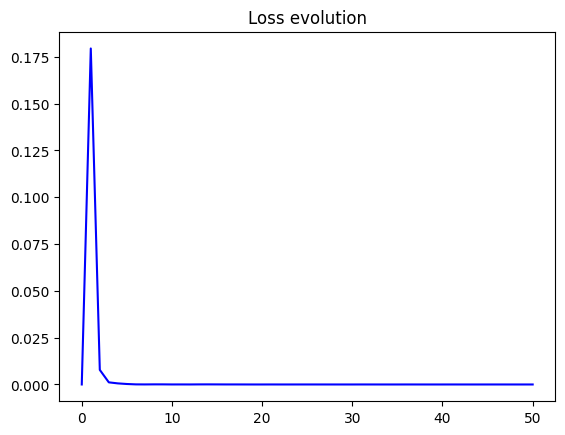

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(agent.loss_evolution,color='blue')
ax.set_title(f'Loss evolution for {agent.model_file}')
plt.show()
fig.savefig('loss.png')